Setup

In [1]:
import sys
!{sys.executable} -m pip install -U deepposekit

Requirement already up-to-date: deepposekit in c:\users\pranavm\anaconda3\lib\site-packages (0.3.4)


In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'
HOME = HOME +'/Documents/RamanLab'

In [3]:
glob.glob(HOME + '/deepposekit-data/**/**/*annotation*.h5')

['C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data\\datasets\\fly\\annotation_data_release.h5',
 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data\\datasets\\fly\\example_annotation_set.h5',
 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data\\datasets\\locust\\annotation_data_release.h5',
 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data\\datasets\\zebra\\annotation_data_release.h5']

DataGenerator

In [4]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5')

C:\Users\PranavM\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


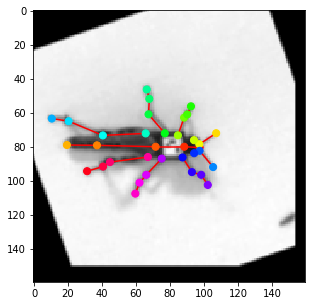

In [5]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

Augmentation Pipeline

In [6]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)

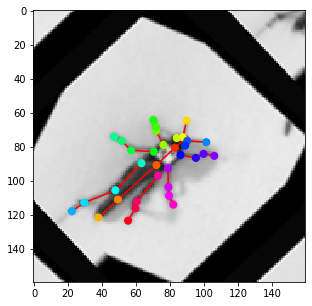

In [7]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

In [8]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 630,
 'n_validation': 70,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (20, 20),
 'n_output_channels': 72,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 700,
 'image_shape': (160, 160, 1),
 'keypoints_shape': (35, 2)}

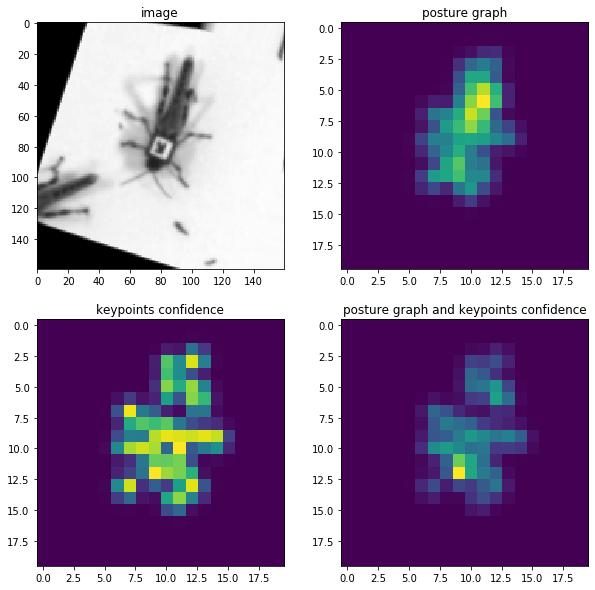

In [9]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

Build Model
    StackedDenseNet? - For more info on StackedDenseNet
    DeepLabCut? - For more info on DeepLabCut

In [10]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP

In [11]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 5,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 630,
 'n_validation': 70,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (20, 20),
 'n_output_channels': 72,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 700,
 'image_shape': (160, 160, 1),
 'keypoints_shape': (35, 2)}

In [12]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:100], batch_size=100) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 51s 5ms/sample
194.68339072278712


In [13]:
logger = Logger(validation_batch_size=10,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

If validation_split=0 for your TrainingGenerator, which will just use the training set for model fitting, make sure to set monitor="loss" instead of monitor="val_loss".

Logger evaluates the validation set (or training set if validation_split=0 in the TrainingGenerator) at the end of each epoch and saves the evaluation data to a HDF5 log file (if filepath is set).

In [14]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

In [15]:
model_checkpoint = ModelCheckpoint(
    HOME + "/deepposekit-data/datasets/locust/best_model_densenet.h5",
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

In [16]:
early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

In [17]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

Fit the Model

In [18]:
model.fit(
    batch_size=16,
    validation_batch_size=10,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=200,
    n_workers=8,
    steps_per_epoch=None,
)

C:\Users\PranavM\Anaconda3\lib\site-packages\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/200
38/39 [============================>.] - ETA: 1s - loss: 834.7505 - output_0_loss: 350.7979 - output_1_loss: 247.9876 - output_2_loss: 235.9650
Epoch 00001: val_loss improved from inf to 1355.52232, saving model to C:\Users\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean: 43.46 (0%:  0.73, 5%:  8.56, 25%: 24.68, 50%: 40.47, 75%: 60.53, 95%: 85.02, 100%: 151.79) 
confidence - mean:  0.01 (0%:  0.00, 5%:  0.00, 25%:  0.00, 50%:  0.01, 75%:  0.01, 95%:  0.01, 100%:  0.06) 

39/39 [==============================] - 53s 1s/step - loss: 826.5293 - output_0_loss: 347.2510 - output_1_loss: 245.5618 - output_2_loss: 233.7164 - val_loss: 1355.5223 - val_output_0_loss: 431.8549 - val_output_1_loss: 471.6739 - val_output_2_loss: 451.9936
Epoch 2/200
38/39 [============================>.] - ETA: 0s - loss: 446.2597 - output_0_loss: 166.0584 - output_1_loss: 141.9930 - output_2_loss: 138.2083
Epoch 00002: val_loss i

Epoch 12/200
38/39 [============================>.] - ETA: 1s - loss: 189.1052 - output_0_loss: 79.5392 - output_1_loss: 63.2523 - output_2_loss: 46.3137
Epoch 00012: val_loss improved from 234.27930 to 204.38099, saving model to C:\Users\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  2.99 (0%:  0.07, 5%:  0.47, 25%:  1.21, 50%:  1.98, 75%:  3.27, 95%:  7.86, 100%: 65.87) 
confidence - mean:  0.55 (0%:  0.07, 5%:  0.29, 25%:  0.45, 50%:  0.57, 75%:  0.65, 95%:  0.75, 100%:  0.89) 

39/39 [==============================] - 56s 1s/step - loss: 188.6241 - output_0_loss: 79.4038 - output_1_loss: 63.0762 - output_2_loss: 46.1440 - val_loss: 204.3810 - val_output_0_loss: 87.3505 - val_output_1_loss: 66.9960 - val_output_2_loss: 50.0345
Epoch 13/200
38/39 [============================>.] - ETA: 0s - loss: 193.1184 - output_0_loss: 81.4282 - output_1_loss: 63.1813 - output_2_loss: 48.5089
Epoch 00013: val_loss did not 

Epoch 23/200
38/39 [============================>.] - ETA: 0s - loss: 129.9324 - output_0_loss: 64.1073 - output_1_loss: 35.3394 - output_2_loss: 30.4857
Epoch 00023: val_loss did not improve from 137.98879
evaluation_metrics: 
euclidean - mean:  2.51 (0%:  0.01, 5%:  0.42, 25%:  1.01, 50%:  1.72, 75%:  2.87, 95%:  6.89, 100%: 44.22) 
confidence - mean:  0.68 (0%:  0.04, 5%:  0.34, 25%:  0.59, 50%:  0.71, 75%:  0.81, 95%:  0.90, 100%:  1.11) 

39/39 [==============================] - 50s 1s/step - loss: 130.0090 - output_0_loss: 64.1164 - output_1_loss: 35.3756 - output_2_loss: 30.5170 - val_loss: 145.2817 - val_output_0_loss: 68.0529 - val_output_1_loss: 41.1352 - val_output_2_loss: 36.0936
Epoch 24/200
38/39 [============================>.] - ETA: 0s - loss: 121.9539 - output_0_loss: 61.7887 - output_1_loss: 32.3863 - output_2_loss: 27.7789
Epoch 00024: val_loss improved from 137.98879 to 120.53667, saving model to C:\Users\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/

Epoch 45/200
38/39 [============================>.] - ETA: 0s - loss: 75.8421 - output_0_loss: 33.6357 - output_1_loss: 22.0818 - output_2_loss: 20.1247
Epoch 00045: val_loss did not improve from 80.60192
evaluation_metrics: 
euclidean - mean:  1.65 (0%:  0.01, 5%:  0.29, 25%:  0.68, 50%:  1.16, 75%:  1.86, 95%:  4.42, 100%: 38.53) 
confidence - mean:  0.74 (0%:  0.06, 5%:  0.46, 25%:  0.64, 50%:  0.75, 75%:  0.85, 95%:  1.02, 100%:  1.17) 

39/39 [==============================] - 43s 1s/step - loss: 76.1365 - output_0_loss: 33.7282 - output_1_loss: 22.1864 - output_2_loss: 20.2219 - val_loss: 83.1264 - val_output_0_loss: 37.1386 - val_output_1_loss: 23.9931 - val_output_2_loss: 21.9948
Epoch 46/200
38/39 [============================>.] - ETA: 0s - loss: 71.2591 - output_0_loss: 31.8249 - output_1_loss: 20.6301 - output_2_loss: 18.8040
Epoch 00046: val_loss did not improve from 80.60192
evaluation_metrics: 
euclidean - mean:  1.64 (0%:  0.01, 5%:  0.27, 25%:  0.69, 50%:  1.15, 75%:  

evaluation_metrics: 
euclidean - mean:  1.56 (0%:  0.00, 5%:  0.28, 25%:  0.64, 50%:  1.06, 75%:  1.67, 95%:  3.95, 100%: 67.56) 
confidence - mean:  0.78 (0%:  0.05, 5%:  0.53, 25%:  0.69, 50%:  0.79, 75%:  0.89, 95%:  0.98, 100%:  1.09) 

39/39 [==============================] - 39s 992ms/step - loss: 64.5191 - output_0_loss: 27.5983 - output_1_loss: 19.3084 - output_2_loss: 17.6124 - val_loss: 63.4221 - val_output_0_loss: 27.0389 - val_output_1_loss: 18.7930 - val_output_2_loss: 17.5902
Epoch 57/200
38/39 [============================>.] - ETA: 0s - loss: 63.1783 - output_0_loss: 26.8417 - output_1_loss: 19.0048 - output_2_loss: 17.3317
Epoch 00057: val_loss did not improve from 63.42210
evaluation_metrics: 
euclidean - mean:  1.64 (0%:  0.02, 5%:  0.27, 25%:  0.64, 50%:  1.07, 75%:  1.71, 95%:  4.17, 100%: 67.59) 
confidence - mean:  0.75 (0%:  0.03, 5%:  0.51, 25%:  0.67, 50%:  0.76, 75%:  0.85, 95%:  0.94, 100%:  1.04) 

39/39 [==============================] - 40s 1s/step - loss

Epoch 68/200
38/39 [============================>.] - ETA: 0s - loss: 58.5505 - output_0_loss: 23.4439 - output_1_loss: 18.3375 - output_2_loss: 16.7691
Epoch 00068: val_loss did not improve from 60.18791
evaluation_metrics: 
euclidean - mean:  1.55 (0%:  0.03, 5%:  0.29, 25%:  0.64, 50%:  1.05, 75%:  1.71, 95%:  4.03, 100%: 68.55) 
confidence - mean:  0.77 (0%:  0.06, 5%:  0.54, 25%:  0.69, 50%:  0.78, 75%:  0.86, 95%:  0.97, 100%:  1.10) 

39/39 [==============================] - 49s 1s/step - loss: 58.4203 - output_0_loss: 23.3958 - output_1_loss: 18.2862 - output_2_loss: 16.7383 - val_loss: 62.0605 - val_output_0_loss: 24.6194 - val_output_1_loss: 19.3088 - val_output_2_loss: 18.1323
Epoch 69/200
38/39 [============================>.] - ETA: 1s - loss: 55.9894 - output_0_loss: 22.5231 - output_1_loss: 17.5060 - output_2_loss: 15.9603
Epoch 00069: val_loss did not improve from 60.18791
evaluation_metrics: 
euclidean - mean:  1.50 (0%:  0.01, 5%:  0.25, 25%:  0.63, 50%:  1.03, 75%:  

Epoch 80/200
38/39 [============================>.] - ETA: 0s - loss: 54.1417 - output_0_loss: 20.8500 - output_1_loss: 17.2599 - output_2_loss: 16.0319
Epoch 00080: val_loss improved from 56.15039 to 54.34881, saving model to C:\Users\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  1.42 (0%:  0.03, 5%:  0.27, 25%:  0.64, 50%:  1.01, 75%:  1.64, 95%:  3.68, 100%: 27.79) 
confidence - mean:  0.77 (0%:  0.07, 5%:  0.54, 25%:  0.68, 50%:  0.77, 75%:  0.87, 95%:  0.97, 100%:  1.11) 

39/39 [==============================] - 44s 1s/step - loss: 53.8377 - output_0_loss: 20.7404 - output_1_loss: 17.1584 - output_2_loss: 15.9389 - val_loss: 54.3488 - val_output_0_loss: 21.0469 - val_output_1_loss: 17.1010 - val_output_2_loss: 16.2009
Epoch 81/200
38/39 [============================>.] - ETA: 0s - loss: 51.8217 - output_0_loss: 20.0264 - output_1_loss: 16.4438 - output_2_loss: 15.3516
Epoch 00081: val_loss did not improv

evaluation_metrics: 
euclidean - mean:  1.43 (0%:  0.01, 5%:  0.26, 25%:  0.62, 50%:  1.00, 75%:  1.63, 95%:  3.73, 100%: 26.40) 
confidence - mean:  0.78 (0%:  0.16, 5%:  0.57, 25%:  0.70, 50%:  0.79, 75%:  0.88, 95%:  0.97, 100%:  1.08) 

39/39 [==============================] - 40s 1s/step - loss: 47.8818 - output_0_loss: 18.4182 - output_1_loss: 15.3720 - output_2_loss: 14.0916 - val_loss: 50.5799 - val_output_0_loss: 19.2280 - val_output_1_loss: 16.0035 - val_output_2_loss: 15.3484
Epoch 92/200
38/39 [============================>.] - ETA: 0s - loss: 52.1793 - output_0_loss: 19.8932 - output_1_loss: 16.7966 - output_2_loss: 15.4894
Epoch 00092: val_loss did not improve from 47.68120
evaluation_metrics: 
euclidean - mean:  1.88 (0%:  0.02, 5%:  0.28, 25%:  0.70, 50%:  1.14, 75%:  1.99, 95%:  4.84, 100%: 67.46) 
confidence - mean:  0.70 (0%:  0.02, 5%:  0.41, 25%:  0.62, 50%:  0.72, 75%:  0.81, 95%:  0.91, 100%:  1.07) 

39/39 [==============================] - 41s 1s/step - loss: 5

Epoch 115/200
38/39 [============================>.] - ETA: 0s - loss: 41.6878 - output_0_loss: 15.7496 - output_1_loss: 13.5452 - output_2_loss: 12.3930
Epoch 00115: val_loss did not improve from 44.10167
evaluation_metrics: 
euclidean - mean:  1.30 (0%:  0.01, 5%:  0.23, 25%:  0.56, 50%:  0.94, 75%:  1.48, 95%:  3.48, 100%: 24.48) 
confidence - mean:  0.78 (0%:  0.12, 5%:  0.56, 25%:  0.69, 50%:  0.78, 75%:  0.88, 95%:  0.97, 100%:  1.10) 

39/39 [==============================] - 35s 906ms/step - loss: 41.3471 - output_0_loss: 15.6293 - output_1_loss: 13.4310 - output_2_loss: 12.2868 - val_loss: 47.6572 - val_output_0_loss: 17.8634 - val_output_1_loss: 15.3341 - val_output_2_loss: 14.4597
Epoch 116/200
38/39 [============================>.] - ETA: 0s - loss: 50.7397 - output_0_loss: 19.3524 - output_1_loss: 16.3204 - output_2_loss: 15.0668
Epoch 00116: val_loss did not improve from 44.10167
evaluation_metrics: 
euclidean - mean: 26.24 (0%:  0.08, 5%:  0.54, 25%:  1.40, 50%:  3.29, 7

Epoch 127/200
38/39 [============================>.] - ETA: 0s - loss: 51.4720 - output_0_loss: 19.0901 - output_1_loss: 16.7678 - output_2_loss: 15.6141
Epoch 00127: val_loss did not improve from 44.10167
evaluation_metrics: 
euclidean - mean:  1.54 (0%:  0.00, 5%:  0.26, 25%:  0.66, 50%:  1.06, 75%:  1.68, 95%:  4.00, 100%: 47.68) 
confidence - mean:  0.76 (0%:  0.11, 5%:  0.52, 25%:  0.67, 50%:  0.76, 75%:  0.86, 95%:  0.96, 100%:  1.11) 

39/39 [==============================] - 37s 944ms/step - loss: 51.7959 - output_0_loss: 19.2034 - output_1_loss: 16.8746 - output_2_loss: 15.7180 - val_loss: 61.0515 - val_output_0_loss: 22.4746 - val_output_1_loss: 19.8627 - val_output_2_loss: 18.7142
Epoch 128/200
38/39 [============================>.] - ETA: 0s - loss: 51.7371 - output_0_loss: 19.2994 - output_1_loss: 16.9027 - output_2_loss: 15.5351
Epoch 00128: val_loss did not improve from 44.10167
evaluation_metrics: 
euclidean - mean:  1.51 (0%:  0.02, 5%:  0.23, 25%:  0.59, 50%:  1.01, 7

Epoch 139/200
38/39 [============================>.] - ETA: 0s - loss: 41.4473 - output_0_loss: 15.8444 - output_1_loss: 13.4706 - output_2_loss: 12.1324
Epoch 00139: val_loss did not improve from 44.10167
evaluation_metrics: 
euclidean - mean:  1.45 (0%:  0.01, 5%:  0.23, 25%:  0.54, 50%:  0.93, 75%:  1.49, 95%:  3.61, 100%: 68.17) 
confidence - mean:  0.79 (0%:  0.04, 5%:  0.59, 25%:  0.71, 50%:  0.79, 75%:  0.88, 95%:  0.98, 100%:  1.06) 

39/39 [==============================] - 40s 1s/step - loss: 41.4148 - output_0_loss: 15.8423 - output_1_loss: 13.4583 - output_2_loss: 12.1142 - val_loss: 47.3806 - val_output_0_loss: 17.4298 - val_output_1_loss: 15.4587 - val_output_2_loss: 14.4920
Epoch 140/200
38/39 [============================>.] - ETA: 0s - loss: 40.2110 - output_0_loss: 15.4595 - output_1_loss: 13.0289 - output_2_loss: 11.7226
Epoch 00140: val_loss did not improve from 44.10167
evaluation_metrics: 
euclidean - mean:  1.41 (0%:  0.02, 5%:  0.22, 25%:  0.55, 50%:  0.95, 75%:

Epoch 162/200
38/39 [============================>.] - ETA: 0s - loss: 37.4278 - output_0_loss: 14.4029 - output_1_loss: 12.1525 - output_2_loss: 10.8724
Epoch 00162: val_loss did not improve from 42.00990
evaluation_metrics: 
euclidean - mean:  1.37 (0%:  0.02, 5%:  0.23, 25%:  0.56, 50%:  0.91, 75%:  1.48, 95%:  3.33, 100%: 68.58) 
confidence - mean:  0.80 (0%:  0.04, 5%:  0.60, 25%:  0.72, 50%:  0.80, 75%:  0.89, 95%:  1.00, 100%:  1.07) 

39/39 [==============================] - 45s 1s/step - loss: 37.5315 - output_0_loss: 14.4366 - output_1_loss: 12.1870 - output_2_loss: 10.9079 - val_loss: 44.0817 - val_output_0_loss: 16.2034 - val_output_1_loss: 14.3597 - val_output_2_loss: 13.5186
Epoch 163/200
38/39 [============================>.] - ETA: 0s - loss: 37.2194 - output_0_loss: 14.3326 - output_1_loss: 12.0386 - output_2_loss: 10.8483
Epoch 00163: val_loss did not improve from 42.00990
evaluation_metrics: 
euclidean - mean:  1.37 (0%:  0.01, 5%:  0.22, 25%:  0.56, 50%:  0.91, 75%:

Epoch 174/200
38/39 [============================>.] - ETA: 0s - loss: 35.1150 - output_0_loss: 13.5990 - output_1_loss: 11.3493 - output_2_loss: 10.1668
Epoch 00174: val_loss did not improve from 42.00990
evaluation_metrics: 
euclidean - mean:  1.35 (0%:  0.01, 5%:  0.22, 25%:  0.53, 50%:  0.90, 75%:  1.45, 95%:  3.29, 100%: 68.55) 
confidence - mean:  0.80 (0%:  0.05, 5%:  0.60, 25%:  0.72, 50%:  0.80, 75%:  0.89, 95%:  0.99, 100%:  1.09) 

39/39 [==============================] - 36s 935ms/step - loss: 35.1395 - output_0_loss: 13.6073 - output_1_loss: 11.3569 - output_2_loss: 10.1752 - val_loss: 42.2063 - val_output_0_loss: 15.4877 - val_output_1_loss: 13.6689 - val_output_2_loss: 13.0497
Epoch 175/200
38/39 [============================>.] - ETA: 0s - loss: 35.9334 - output_0_loss: 13.8950 - output_1_loss: 11.6309 - output_2_loss: 10.4075
Epoch 00175: val_loss did not improve from 42.00990
evaluation_metrics: 
euclidean - mean:  1.36 (0%:  0.01, 5%:  0.22, 25%:  0.54, 50%:  0.89, 7

Epoch 185/200
38/39 [============================>.] - ETA: 0s - loss: 35.3687 - output_0_loss: 13.7170 - output_1_loss: 11.4509 - output_2_loss: 10.2009
Epoch 00185: val_loss improved from 41.57606 to 41.48180, saving model to C:\Users\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  1.35 (0%:  0.01, 5%:  0.22, 25%:  0.52, 50%:  0.89, 75%:  1.43, 95%:  3.29, 100%: 68.40) 
confidence - mean:  0.80 (0%:  0.04, 5%:  0.59, 25%:  0.72, 50%:  0.80, 75%:  0.89, 95%:  0.99, 100%:  1.08) 

39/39 [==============================] - 42s 1s/step - loss: 35.2648 - output_0_loss: 13.6780 - output_1_loss: 11.4151 - output_2_loss: 10.1717 - val_loss: 41.4818 - val_output_0_loss: 15.2399 - val_output_1_loss: 13.4215 - val_output_2_loss: 12.8204
Epoch 186/200
38/39 [============================>.] - ETA: 1s - loss: 34.9878 - output_0_loss: 13.5432 - output_1_loss: 11.3454 - output_2_loss: 10.0993
Epoch 00186: val_loss did not impr

Epoch 196/200
38/39 [============================>.] - ETA: 0s - loss: 34.2440 - output_0_loss: 13.3009 - output_1_loss: 11.0915 - output_2_loss: 9.8516
Epoch 00196: val_loss improved from 40.80362 to 40.74623, saving model to C:\Users\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean:  1.34 (0%:  0.00, 5%:  0.22, 25%:  0.53, 50%:  0.89, 75%:  1.45, 95%:  3.20, 100%: 68.30) 
confidence - mean:  0.80 (0%:  0.05, 5%:  0.60, 25%:  0.72, 50%:  0.80, 75%:  0.89, 95%:  0.99, 100%:  1.08) 

39/39 [==============================] - 45s 1s/step - loss: 34.3319 - output_0_loss: 13.3399 - output_1_loss: 11.1245 - output_2_loss: 9.8674 - val_loss: 40.7462 - val_output_0_loss: 14.9791 - val_output_1_loss: 13.1878 - val_output_2_loss: 12.5793
Epoch 197/200
38/39 [============================>.] - ETA: 0s - loss: 35.4016 - output_0_loss: 13.6844 - output_1_loss: 11.5028 - output_2_loss: 10.2144
Epoch 00197: val_loss did not improv

Load and Resume Training

In [ ]:
model = load_model(
    HOME + "/deepposekit-data/datasets/locust/best_model_densenet.h5",
    augmenter=augmenter,
    generator=data_generator,
)

In [ ]:
model.fit(
    batch_size=5,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=30,
    n_workers=8,
    steps_per_epoch=None,
)